<a href="https://colab.research.google.com/github/Frans-Grau/P5-Forecasting/blob/main/M_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.arima.model import ARIMA

In [6]:
### Load the Datasets
#originalyy downloaded from https://www.kaggle.com/datasets/sherrytp/airline-delay-analy
df2016 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2016.csv')
df2017 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2017.csv')
df2018 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2018.csv')

### Quick preprocessing
df_all = pd.concat([df2016,df2017,df2018], ignore_index = True, axis = 0)
df_all.drop(['Unnamed: 0','CANCELLED','DIVERTED'], axis=1, inplace= True)
df_all.dropna(inplace=True)
df_all['FL_DATE'] = pd.to_datetime(df_all['FL_DATE'])
df_all['AIRLINE'] = df_all['OP_CARRIER'].apply(lambda x: 'Delta Airlines' if x == 'DL' else 'Southwest Airlines' if x=='WN' else 'American Airlines' if x=='AA'
else 'JetBlue Airways' if x=='B6' else 'SkyWest Airlines' if x=='OO' else 'Atlantic Southeast Airlines' if x == 'EV' else 'United Airlines' if x == 'UA'
else 'Pinnacle Airlines' if x == '9E' else 'Spirit Airlines' if x== 'NK' else 'Alaska Airlines' if x == 'AS' else 'Virgin America' if x == 'VX' else 'Frontier' if x =='F9'
else 'Republic Airlines' if x == 'YX'else 'Hawaiian Airlines' if x == 'HA' else 'Envoy Air' if x == 'MQ' else 'Air Shuttle' if x == 'YV' else 'Allegiant Air' if x=='G4'
else 'Comair')
df_all.head()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,AIR_TIME,DISTANCE,AIRLINE
0,2016-01-01,DL,ATL,GRR,2125,2130.0,5.0,2321,2319.0,92.0,640.0,Delta Airlines
1,2016-01-01,DL,LAX,ATL,2255,2256.0,1.0,600,547.0,207.0,1947.0,Delta Airlines
2,2016-01-01,DL,ATL,BNA,1233,1356.0,83.0,1239,1402.0,38.0,214.0,Delta Airlines
3,2016-01-01,DL,ATL,JAX,945,946.0,1.0,1050,1053.0,45.0,270.0,Delta Airlines
4,2016-01-01,DL,ATL,OKC,2110,2107.0,-3.0,2236,2224.0,116.0,761.0,Delta Airlines


In [7]:
!pip install pmdarima
from pmdarima.arima import auto_arima
auto_arima(np.random.randint(1,40, 21))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

##2.1) Seasonal analysis

In [17]:
#create the time series df
df_delay = df_all.groupby('FL_DATE')['DEP_DELAY'].mean().reset_index()
df_delay = df_delay.sort_values('FL_DATE').set_index('FL_DATE')
df_delay

,DEP_DELAY
FL_DATE,
2016-01-01,6.106262
2016-01-02,9.728279
2016-01-03,15.104025
2016-01-04,10.579281
2016-01-05,12.293303
...,...
2018-12-27,20.029929
2018-12-28,32.150881
2018-12-29,15.529323


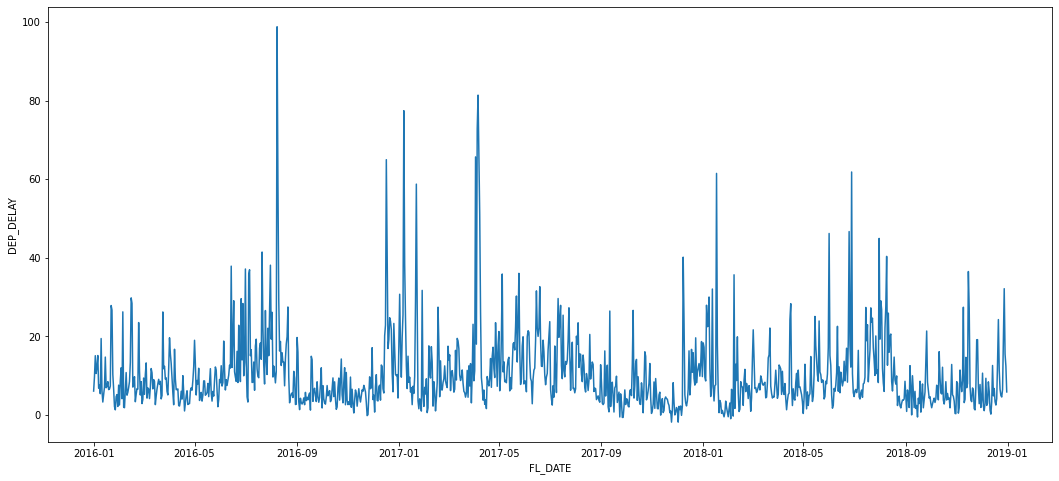

In [18]:
#plot of the time series
sns.lineplot(data = df_delay , x = df_delay.index, y = df_delay['DEP_DELAY'])

In [13]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
sig = df_delay['DEP_DELAY'].resample('W').mean()
decomposition = sm.tsa.seasonal_decompose(x = sig.rolling(100).mean().dropna(), period=14, model='additive')
fig = decomposition.plot()
plt.show()

AttributeError: ignored

##2.2) Autocorrelation

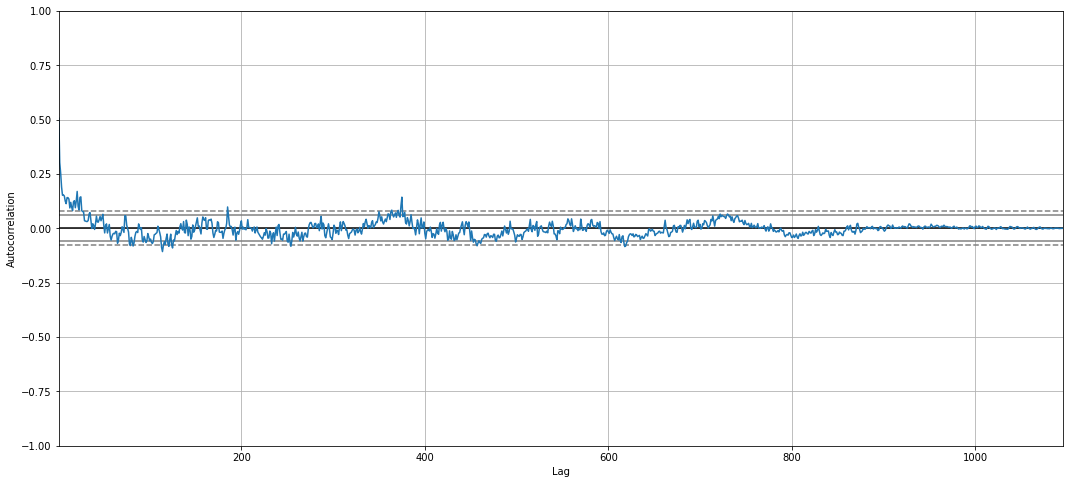

In [14]:
from pandas.plotting import autocorrelation_plot
 
autocorrelation_plot(df_delay[:100000]) #this plot is plotting the correlations values by lag
plt.show()

##2.3) Stationary test

In [15]:
from statsmodels.tsa.stattools import kpss

kpss(df_delay, regression='c', nlags = 'auto')
#We reject the null hypothesis (P=0.1 < alpha=0.05), so it's stationary with 95% confidence

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.28374007132757506,
 0.1,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [16]:
kpss(df_delay, regression='ct', nlags = 'auto')

#We reject the null hypothesis (P=0.06 < alpha=0.05), so it's stationary with 95% confidence

(0.14074002491913623,
 0.05974069459419215,
 15,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

##2.4) ARIMA Model

In [22]:
### ARIMA 
# Create the train set
train_set = df_delay[(df_delay.index >= '2016/01/01') & (df_delay.index <= '2017/12/31')]
print('The minimum date we have is', train_set.index.min(), 'and the maximum date is ',  train_set.index.max())

# Create the test set
test_set = df_delay[~df_delay.index.isin(train_set.index)]
print('The minimum date we have is', test_set.index.min(), 'and the maximum date is ',  test_set.index.max())

The minimum date we have is 2016-01-01 00:00:00 and the maximum date is  2017-12-31 00:00:00
The minimum date we have is 2018-01-01 00:00:00 and the maximum date is  2018-12-31 00:00:00


In [26]:
#tune the parameters p, d, q using auto_arima
!pip install pmdarima
from pmdarima.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
auto_arima(df_delay)
#best tuning with: p = 2, d = 0, q = 1

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True)

In [29]:
#fit model to the optimized parameters
arima_model = ARIMA(train_set.values, order=(2,0,1))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

#forecast
arima_model_fit.forecast()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  731
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2604.126
Date:                Wed, 04 Jan 2023   AIC                           5218.253
Time:                        16:58:41   BIC                           5241.225
Sample:                             0   HQIC                          5227.115
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7743      2.080      5.181      0.000       6.698      14.850
ar.L1          1.4191      0.052     27.481      0.000       1.318       1.520
ar.L2         -0.4364      0.041    -10.520      0.0

array([10.26302856])

In [21]:
#check if it makes sense, the value makes sense with the whole dataframe and is actually close to the mean
df_delay.mean()

DEP_DELAY    10.339835
dtype: float64

In [ ]:
#create a plot with the prediction vs real values
#create a column with the prediction



In [ ]:
#lineplot the residuals

# # line plot of residuals
# residuals = DataFrame(model_fit.resid)
# residuals.plot()
# pyplot.show()
# # density plot of residuals
# residuals.plot(kind='kde')
# pyplot.show()
# # summary stats of residuals
# print(residuals.describe())